# Overfit and underfit

## Table of contents
Setup   
The Higgs Dataset   
Demonstrate overfiting
   - Training procedure
   - Tiny model
   - Small model
   - Medium model
   - Large model
   - Plot the training and validation lossses
   - View in TensorBoard   

Strategies to prevent overfiting
   - Add weight regularization
   - Add dropout
   - Combined L2 + dropout
   - View in TensorBoard   

Conclosions

# Setup

시작하기 전 필요한 패키지를 가져옵시다!

In [1]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.4.0


In [2]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-0wmyx_0d
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0e2abff4864c2895987c866a18db399991e0d7f50_-py3-none-any.whl size=150455 sha256=3e3c10cbcd3c455fd419e41e0bb42e6a8d6b78e5064dfbca7b7f0d876b9008cb
  Stored in directory: /tmp/pip-ephem-wheel-cache-ua72pajq/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [4]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

# The Higgs Dataset

이 튜토리얼의 목표는 입자 물리학의 수행이 아니므로 데이터 세트의 세부 사항에는 집착하지 않아도 됩니다!   
여기에는 각각 28개의 feature가 있고 binary class label이 있는 11,000,000개의 예제가 포함되어 있습니다!

In [5]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz',
                             'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816409600/2816407858 [==============================] - 28s 0us/step


In [6]:
FEATURES = 28

**tf.data.experimental.CsvDataset** 의 클래스는 csv, gzip 파일로 읽을 수 있습니다.

In [7]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1),
                                     compression_type="GZIP")

csv는 각각의 리스트에 대한 스칼라 목록을 반환합니다. 또한, 다음 함수는 해당 스칼라 목록을 (feature_vector, label) 쌍으로 다시 압축합니다.

In [8]:
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:],1)
    return features, label

TensorFlow는 대규모 데이터 배치에서 작업할 때 가장 효율적입니다.

따라서 각 행을 개별적으로 다시 포장하는 대신 Dataset 10,000개 배치를 만들어 'pack_row' 각 배치에 기능을 적용한 배치를 각각 다음 분할하는 작업을 합니다.

In [9]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

packed_ds의 기록을 보면, 완벽하게 정규화 되진 않았지만 이 튜토리얼에서는 이것으로 충분합니다.

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


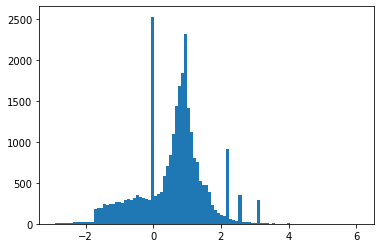

In [10]:
for features,label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins = 101)

이 튜토리얼을 비교적 짧게 유지하려면 처음 1000개의 샘플만 검증에 사용하고 다음 10,000개는 훈련에 사용합니다.

In [11]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

Dataset.skip 및 Dataset.take 메서드를 사용합니다.

동시에 Dataset.cache 메서드를 사용하여 각 loader가 각 에포크 파일에서 데이터를 다시 읽을 필요가 없도록 만들어줍니다.

In [12]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [13]:
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

이런 데이터세트는 개별적인 예시를 반환합니다. **.batch** 메서드를 사용하여 훈련에 적합한 크기의 배치를 만듭니다. 일괄 처리하기 전에 **.shuffle** 과 **.repeat** 훈련 세트도 기억해야 합니다!

In [14]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

# Demonstrate overfitting
### Training procedure

훈련하는 동안 학습률을 점진적으로 낮추면 많은 모델이 더 잘 훈련됩니다. optimizers.schedules 시간이 지남에 따라 학습률을 줄입니다.

In [15]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

위의 코드 **schedules.InverseTimeDecay**는 1000 epoch에서 학습률을 기본 속도의 1/2, 2000 epoch에서 1/3 등으로 쌍곡선적으로 감소하도록 설정합니다.

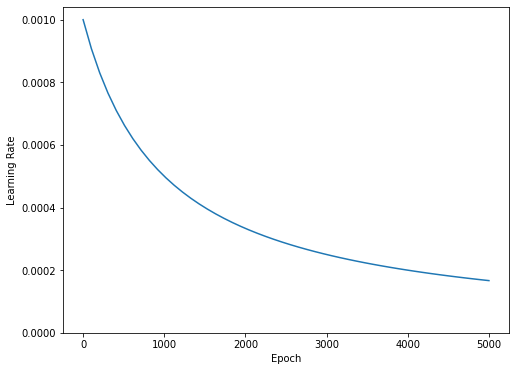

In [16]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

이 튜토리얼의 훈련은 짧은 시간 동안 실행됩니다. logging noise를 줄이려면 각 epoch에 대해 **tfdocs.EpochDots**을 이용하여 **.** 을 통해 100 epoch마다 전체 matrix를 보여줍니다.

다음은 **callbacks.EarlyStopping** 을 통해 불필요한 훈련 시간을 피할 수 있습니다.이 콜백은 val_loss가 아니라 **val_binary_crossentropy** 를 모니터링하도록 설정되어 있습니다. 

**callbacks.TensorBoard**는 훈련에 대한 TensorBoard 로그를 생성하는데 사용합니다.

In [17]:
def get_callbacks(name):
    return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

마찬가지로 각 모델은 똑같이 Model.compile 과 Model.fit 설정이 필요하다.

In [18]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
        model.compile(optimizer=optimizer,
                      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      metrics=[
                          tf.keras.losses.BinaryCrossentropy(
                              from_logits=True, name='binary_crossentropy'),
                          'accuracy'])

    model.summary()
    
    history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
    return history

### Tiny model
Start by training a model:

In [19]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [20]:
size_histories = {}

In [21]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4910,  binary_crossentropy:0.8111,  loss:0.8111,  val_accuracy:0.4980,  val_binary_crossentropy:0.7685,  val_loss:0.7685,  
....................................................................................................
Epoch: 100, accuracy:0.5931,  binary_crossentropy:0.6274,  loss:0.6274,  val_accuracy:0.5780,  val_binary_crossentropy:0.6350,  val_loss:0.6350,  
....................................................................................................
Epoch: 200, accuracy:0.61

Now check how the model did:

(0.5, 0.7)

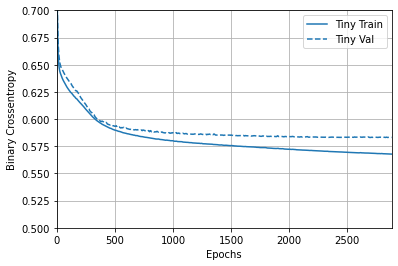

In [22]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

### Small model
To see if you can beat the performance of the small model, progressively train some larger models.

Try two hidden layers with 16 units each:

In [23]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [24]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4772,  binary_crossentropy:0.7649,  loss:0.7649,  val_accuracy:0.4890,  val_binary_crossentropy:0.7184,  val_loss:0.7184,  
....................................................................................................
Epoch: 100, accuracy:0.6298,  binary_crossentropy:0.6108,  loss:0.6108,  val_accuracy:0.5890,  val_binary_crossentropy:0.6201,  val_loss:0.

### Medium model
Now try 3 hidden layers with 64 units each:

In [25]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

And train the model using the same data:

In [26]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4812,  binary_crossentropy:0.7164,  loss:0.7164,  val_accuracy:0.4710,  val_binary_crossentropy:0.6828,  val_loss:0.6828,  
....................................................................................................
E

### Large model

As an exercise, you can create an even larger model, and see how quickly it begins overfitting. Next, let's add to this benchmark a network that has much more capacity, far more than the problem would warrant:

In [27]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

And, again, train the model using the same data:

In [28]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               14848     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5112,  binary_crossentropy:0.7596,  loss:0.7596,  val_accuracy:0.4840,  val_binary_crossentr

### Plot the training and validation losses
The solid lines show the training loss, and the dashed lines show the validation loss (remember: a lower validation loss indicates a better model).

While building a larger model gives it more power, if this power is not constrained somehow it can easily overfit to the training set.

In this example, typically, only the "Tiny" model manages to avoid overfitting altogether, and each of the larger models overfit the data more quickly. This becomes so severe for the "large" model that you need to switch the plot to a log-scale to really see what's happening.

This is apparent if you plot and compare the validation metrics to the training metrics.
   - It's normal for there to be a small difference.
   - If both metrics are moving in the same direction, everything is fine.
   - If the validation metric begins to stagnate while the training metric continues to improve, you are probably close to overfitting.
   - If the validation metric is going in the wrong direction, the model is clearly overfitting.

Text(0.5, 0, 'Epochs [Log Scale]')

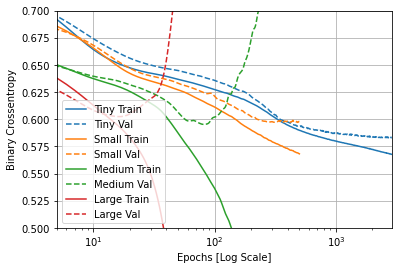

In [29]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

### View in TensorBoard
These models all wrote TensorBoard logs during training.

Open an embedded TensorBoard viewer inside a notebook:

In [30]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

You can view the results of a previous run of this notebook on TensorBoard.dev.

TensorBoard.dev is a managed experience for hosting, tracking, and sharing ML experiments with everyone.

It's also included in an iframe for convenience:

In [31]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

If you want to share TensorBoard results you can upload the logs to TensorBoard.dev by copying the following into a code-cell.

In [32]:
tensorboard dev upload --logdir  {logdir}/sizes

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2021-08-18 07:02:22.511116: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-18 07:02:22.511206: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/tmp/tmpcbw37mcm/tensorboard_logs/sizes

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you ar

# Strategies to prevent overfitting

Before getting into the content of this section copy the training logs from the "Tiny" model above, to use as a baseline for comparison.

In [33]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmp/tmpcbw37mcm/tensorboard_logs/regularizers/Tiny')

In [34]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

### Add weight regularization

이제 가중치 규제를 둘 것입니다. 여기 설명에선 오컴의 면도날을 예시로 듭니다. 오컴의 면도날이란 어떤 현상을 설명할 때 불필요한 가정이 필요없다는 뜻입니다. 조금 더 쉬운 말로 번역하자면, '같은 현상을 설명하는 두 개의 주장이 있다면, 간단한 쪽을 선택하라'라는 뜻인데요. 이 원리를 신경 네트워크에서 학습한 모델에도 적용이 됩니다.

일부 train data와 network architecture가 주어졌을 때, 데이터를 설명할 수 있는 여러 가지 가중치 값이 있고, 또한 앞서 보았듯이 단순한 모델이 복잡한 모델보다 과적합할 가능성이 적다는 것을 확인했습니다.

그래서 우리는 네트워크의 복잡도에 제한을 두어 가중치가 작은 값을 가지도록 만드는 과정이 정칙화이고, 여기서 우리는 가중치의 절댓값에 비례하는 비용이 추가되는 L1 노름, 가중치의 제곱에 비례하는 비용이 추가되는 L2 노름이 있다는 것을 알고 있습니다.

여기서는 simple model이라 하는데요. 단순 모형이란 파라미터 값의 분포가 엔트로피를 갖는 모형을 말한다고 합니다. 따라서 과적합을 완화하는 일반적인 방법은 가중치를 작은 값만 취하도록 하여 네트워크의 복잡성에 제약을 가하는 것이라 정리할 수 있습니다.

l1, l2 등을 통해 가중치 값의 분포가 "regular" 해지고 이 과정을 weight regularization(가중치 정칙화)라고 합니다. 큰 가중치를 갖는 것과 관련된 비용을 네트워크의 손실 함수에 더하면서 이뤄집니다.

노드에서 배웠듯이, L1 규제는 일부 가중치 파라미터를 0으로 만듭니다. L2 규제는 가중치 파라미터를 제한하지만 완전히 0으로 만들지는 않습니다. L2가 더 일반적인 이유 중 하나이고, 여기서도 L2 노름의 예시만 보여주고 있습니다.

In [ ]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

regularizers.l2(0.001) : 가중치 행렬의 모든 원소를 제곱하고 0.001을 곱하여 네트워크의 전체 손실에 더해진다는 의미입니다. 이 규제(패널티)는 훈련할 때만 추가됩니다.

여기서는 binary_crossentropy로 모니터링을 하고 있습니다. 따라서 large 모델에 l2를 적용한 모델이 더 나은 성능을 보여주고 있습니다.

(0.5, 0.7)

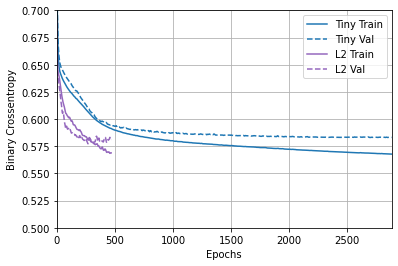

In [36]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

l2 모델은 large의 동일한 수의 파라미터를 가지고 있음에도 과적합에 더 강합니다.

이러한 정칙화에 유의점이 두 가지 있습니다.

1. 사용자만의 training loop를 지정을 해줄 때, regularization losses가 있어야 한다는 점
2. 가중치 패널티를 추가한 다음 손실 함수의 값을 가능한 낮추는 매개변수를 찾는 표준 최적화 과정이 필요하다고 말하고 있습니다.

In [37]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

### Add dropout

앞에는 오버피팅을 억제하는 방식으로 손실 함수에 가중치의 L2 노름을 더한 가중치 감소 방법을 설명했고, 가중치 감소는 간단하게 구현할 수 있고 어느 정도 지나친 학습을 억제할 수 있습니다.
그러나 신경망 모델이 복잡해지면 가중치 감소만으로는 대응하기 어려워져서, 이럴 때는 흔히 드롭아웃이라는 기법을 사용합니다.

드롭아웃은 훈련 때 은닉층의 뉴련을 무작위로 골라 삭제합니다. 이를 zero out이라 말하고, 삭제된 뉴런은 신호를 전달하지 않게 됩니다. 일반적으로 주어진 입력 샘플인 벡터  [0.2, 0.5, 1.3, 0.8, 1.1] 를 반환한다고 가정하면, 드롭아웃을 적용하면 이 벡터는 임의로 분포된 몇 개의 항목이 0이 되는 것을 볼 수 있습니다. [0, 0.5, 1.3, 0, 1.1].

dropout rate는 zero out 되는 피처의 비율이며 일반적으로 0.2~0.5 사이 설정됩니다. 훈련할 땐 삭제할 뉴런을 무작위로 선택하지만, test 때는 모든 뉴런에 신호를 전달합니다. 단, test 때는 각 뉴런을 출력할 때 삭제 안 한 비율을 곱하거나 또는 곱하지 않고 구한다고 합니다.

네트워크에 두 개의 드롭아웃 계층을 추가하여 오버핏을 줄이는 데 얼마나 효과적인지 알아보겠습니다.

In [38]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)              

(0.5, 0.7)

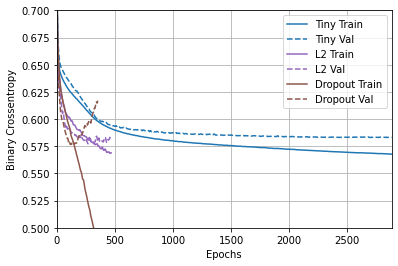

In [39]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

그래프로 확인을 해보았을 때, dropout validation set의 binary crossentropy 가 증가하여 아직까진 tiny model을 이기지 못하고 있습니다.

그 다음은 l2 과 드롭아웃을 합친 모델을 만들어 볼 겁니다.

### Combined L2 + dropout

In [ ]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)              

In [ ]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

확인을 해보니 분홍색 선과 실선이 combine 모델이고 이 모델이 현재까지 가장 좋은 결과를 보여주고 있습니다.

이걸 텐서보드로 확인해보겠습니다.

### View in TensorBoard
These models also recorded TensorBoard logs.

To open an embedded tensorboard viewer inside a notebook, copy the following into a code-cell:

In [ ]:
%tensorboard --logdir {logdir}/regularizers

You can view the results of a previous run of this notebook on TensorDoard.dev.

It's also included in an iframe for convenience:

In [ ]:
display.IFrame(
    src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
    width = "100%",
    height="800px")

This was uploaded with:

In [ ]:
tensorboard dev upload --logdir  {logdir}/regularizers

# Conclusions

To recap: here are the most common ways to prevent overfitting in neural networks:

   - Get more training data.
   - Reduce the capacity of the network.
   - Add weight regularization.
   - Add dropout.

Two important approaches not covered in this guide are:
   - data-augmentation
   - batch normalization

Remember that each method can help on its own, but often combining them can be even more effective.